In [1]:
# install.packages(c("dynamicTreeCut", "cluster", "flashClust", "Hmisc", "reshape", "foreach", "doParallel", "WGCNA") )

In [3]:
library('WGCNA')
library('flashClust')

## WGCNA Analysis on GBM data

#### Input data

In [56]:
cancer = read.csv('./WCGNA_analysis/GBM_tumor.csv', row.names = 1)

In [57]:
dim(cancer)

[1]   153 17004

pickSoftThreshold: will use block size 4000.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4000 of 4000
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1    0.111 -0.925          0.926 581.0000  5.67e+02 1050.00
2      2    0.583 -1.570          0.960 141.0000  1.26e+02  423.00
3      3    0.803 -1.790          0.985  45.8000  3.51e+01  213.00
4      4    0.867 -1.860          0.981  18.2000  1.14e+01  122.00
5      5    0.900 -1.820          0.984   8.3700  4.18e+00   76.20
6      6    0.922 -1.790          0.994   4.3000  1.66e+00   51.50
7      7    0.924 -1.760          0.992   2.4100  7.00e-01   36.20
8      8    0.936 -1.700          0.997   1.4400  3.09e-01   26.10
9      9    0.934 -1.670          0.991   0.9100  1.41e-01   19.30
10    10    0.943 -1.630          0.994   0.6000  6.72e-02   14.90
11    12    0.943 -1.580          0.992   0.2910  1.67e-02    9.59
12    14    0.916 -1.570          0.953  

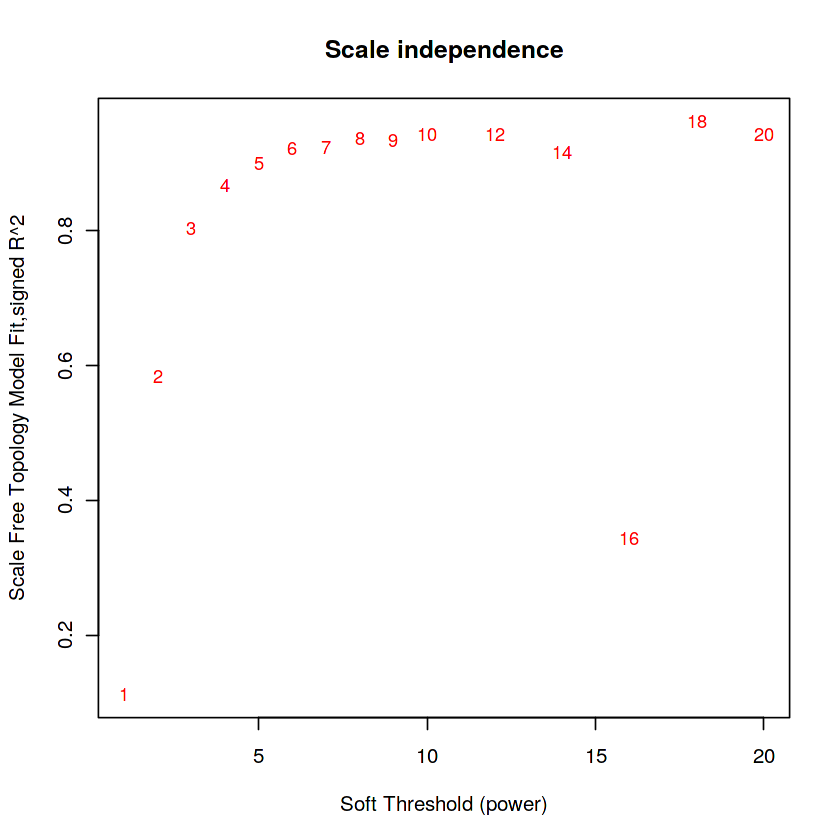

In [58]:
### Get most variable gene list for cancer
cv <- apply(cancer, 2, mad)

# Taking top 4000 by average expression
cancer_top_genes <- cancer[, order(cv, decreasing = T)]
cancer_top_genes <- cancer_top_genes[, 1:4000]

#### Choose Power for scale free topology for cancer 
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))
sft_cancer = pickSoftThreshold(cancer_top_genes, powerVector = powers, verbose = 5, RsquaredCut = 0.95)

plot(sft_cancer$fitIndices[,1], -sign(sft_cancer$fitIndices[,3])*sft_cancer$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft_cancer$fitIndices[,1], -sign(sft_cancer$fitIndices[,3])*sft_cancer$fitIndices[,2],
     labels=powers,cex=0.9,col="red")

#### Choose Power based on highest value of R^2 values to get scale free Topology :

In [59]:
sft_cancer$fitIndices$Power[which.max(sft_cancer$fitIndices$SFT.R.sq)]

[1] 18

#### Now construct modules based on TOM dissimilarity

In [60]:
power = 18

In [61]:
# Preparing for module list for cancer
TOM <- TOMsimilarityFromExpr(cancer_top_genes, networkType = "signed", TOMType = "signed", power = power)

# get dissimilarity matrix from TOM matrix
colnames(TOM) <- rownames(TOM)
dissTOM <- 1 - TOM

# hierarchical clustering of the genes based on the TOM dissimilarity measure
geneTree <- hclust(as.dist(dissTOM), method = "average")

# Set the minimum module size
minModuleSize <- 20

# cut the tree
# the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
dynamicMods <- cutreeDynamic(dendro = geneTree, method = "tree", minClusterSize = minModuleSize)
dynamicColors = labels2colors(dynamicMods)

MEList = moduleEigengenes(cancer_top_genes, colors = dynamicColors)
MEs_cancer = MEList$eigengenes

module_list_cancer <- list()
for (module_index in sort(unique(dynamicMods))){
   module <-  colnames(cancer_top_genes)[which(dynamicMods==module_index)]
   module <- module[!is.na(module)]
   module <- module[module != ""]
   module <- module[module != " "]
   # put brackets around every entrez id so to demarcate 1 genes
   module_list_cancer[[as.character(module_index)]] <- paste(module, collapse = ",")
}
module_list_cancer <- module_list_cancer[sapply(module_list_cancer, nchar) > 0]

TOM calculation: adjacency..
..will not use multithreading.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [62]:
df <- unique(data.frame(dynamicMods, dynamicColors))
df <- df[order(df$dynamicMods),]
rownames(df) <- NULL
df

dynamicMods dynamicColors
1   0          grey         
2   1          turquoise    
3   2          blue         
4   3          brown        
5   4          yellow       
6   5          green        
7   6          red          
8   7          black        
9   8          pink         
10  9          magenta      
11 10          purple       
12 11          greenyellow  
13 12          tan          
14 13          salmon       
15 14          cyan

#### We have assigned a color to each module
Grey contains unassigned genes

In [29]:
table(dynamicColors)

dynamicColors
      black        blue       brown        cyan       green greenyellow 
         44         120          99          22          67          35 
       grey     magenta        pink      purple         red      salmon 
       3014          41          42          36          59          25 
        tan   turquoise      yellow 
         27         274          95 

#### Plot Module Dendogram with all colors (including grey)

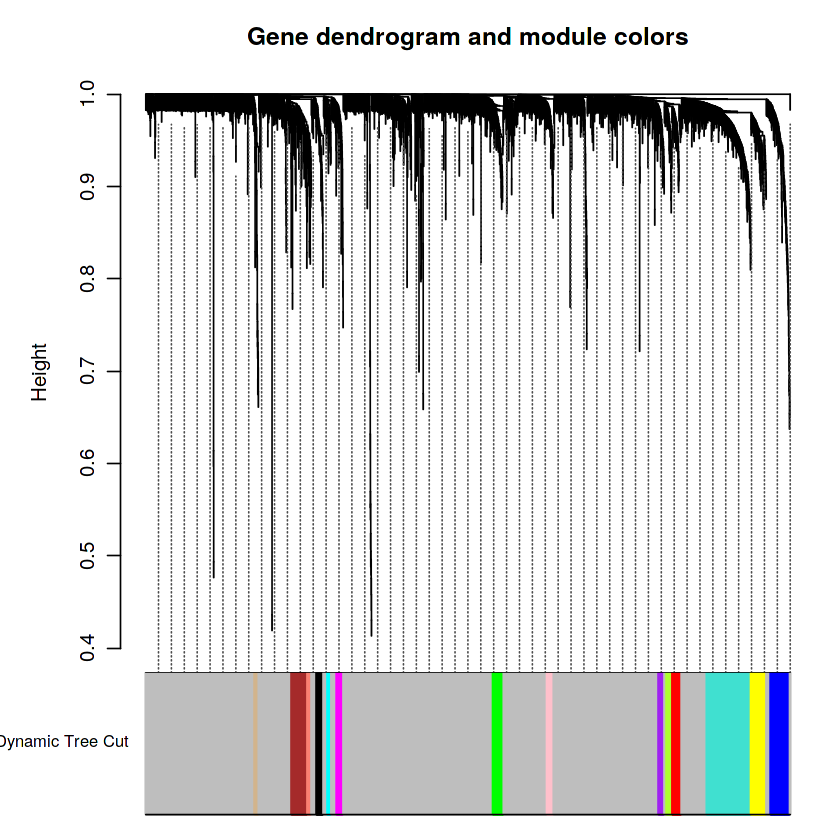

In [30]:
plotDendroAndColors(geneTree, dynamicColors, 
                    "Dynamic Tree Cut", dendroLabels = FALSE,
                    hang = 0.03, addGuide = TRUE,
                    guideHang = 0.05, main = "Gene dendrogram and module colors")

#### Remove the grey module genes as they are the unassigned ones

In [31]:
restGenes = (dynamicColors != "grey")
diss1 = 1 - TOMsimilarityFromExpr(cancer_top_genes[,restGenes], power = power)

TOM calculation: adjacency..
..will not use multithreading.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


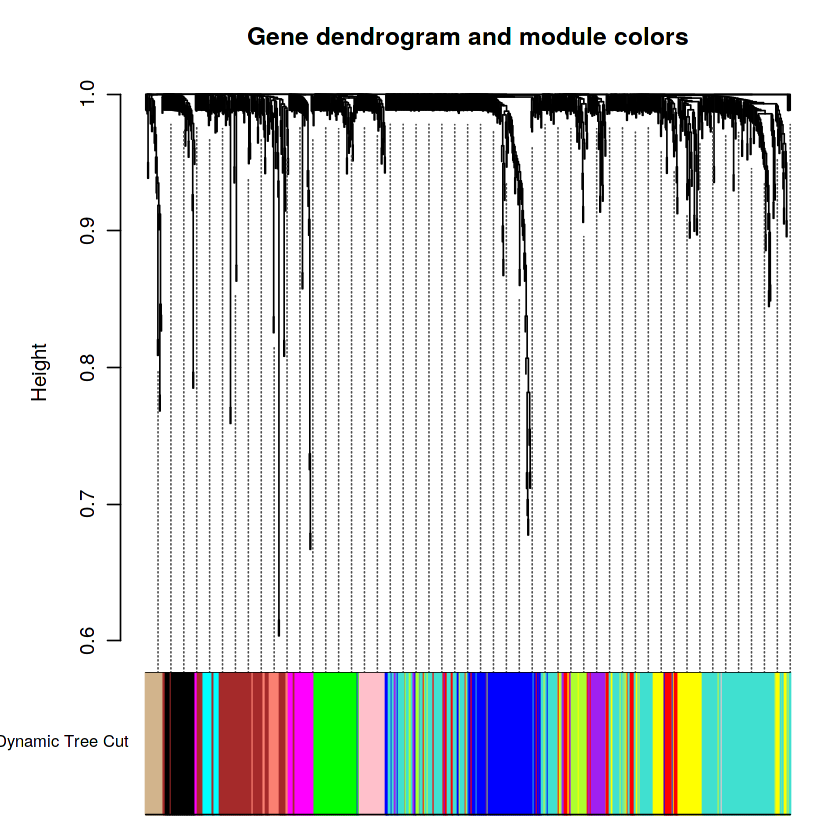

In [32]:
SubGeneNames <- colnames(cancer_top_genes)
colnames(diss1) = rownames(diss1) = SubGeneNames[restGenes]
hier1 = flashClust(as.dist(diss1), method="average" )
plotDendroAndColors(hier1, dynamicColors[restGenes],
                    "Dynamic Tree Cut", dendroLabels = FALSE,
                    hang = 0.03, addGuide = TRUE,
                    guideHang = 0.05, main = "Gene dendrogram and module colors")

#### Get Module Significance Boxplot :

In [33]:
### ---- This needs to be done ------- ###

#### Module Eigengenes (First PC) 

In [34]:
head(MEs_cancer)

MEblack     MEblue      MEbrown     MEcyan       MEgreen     MEgreenyellow
1  0.03070827  0.06890756 -0.04442158 -0.025348326  0.03467060 -0.04567420  
2  0.05783838 -0.04664814  0.10943387  0.083753353 -0.08412170 -0.13082071  
3  0.08201698  0.11700817 -0.02926069 -0.099249482  0.02462201  0.08233779  
4 -0.08325926 -0.04788809  0.02424565  0.086494831  0.01712769 -0.01580568  
5  0.05704744  0.05152402  0.02655763  0.005104401  0.07308530 -0.06219921  
6  0.05956947  0.15289800  0.09362018 -0.042632742 -0.01493148 -0.08328926  
  MEgrey      MEmagenta    MEpink       MEpurple    MEred       MEsalmon    
1  0.02656892 -0.012907623  0.004905057 -0.07018305 -0.03349399 -0.008703635
2 -0.03123866  0.077231949 -0.087298351 -0.10159104 -0.09093535  0.125531334
3  0.09388810 -0.110742521  0.005956649  0.05912996  0.09718590 -0.004993046
4 -0.09966299  0.042984203 -0.155278460  0.02048786 -0.04045198  0.058059430
5  0.04914425 -0.017975402  0.058529828 -0.00644004  0.01852356  0.015803945
6  0.05290865  0.006298478 -0.088317357 -0.01878820  0.03494694  0.104831775
  MEtan       MEturquoise MEyellow    
1  0.15453038 -0.05503273 -0.053776580
2  0.03320566  0.02644565 -0.038640388
3  0.20416105  0.11032287  0.098318799
4  0.03597949  0.01248580 -0.009436797
5  0.04258373  0.09638734  0.056911186
6 -0.01060362  0.17545981  0.117712273

In [35]:
dim(MEs_cancer)

[1] 153  15

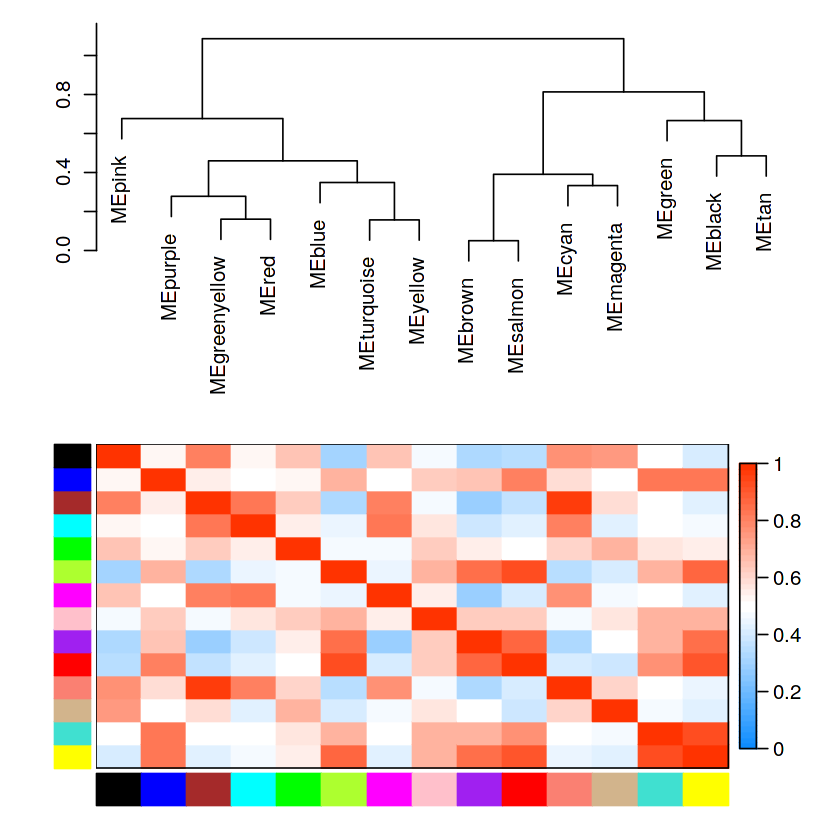

In [36]:
plotEigengeneNetworks(MEs_cancer, "", marDendro = c(0,4,1,2), marHeatmap = c(3,4,1,2))

#### Getting Hub Genes based for each module 

In [37]:
hubGenes <- chooseTopHubInEachModule(
   cancer_top_genes, 
   dynamicColors, 
   omitColors = "grey", 
   power = power, 
   type = "signed")
hubGenes

black        blue       brown        cyan       green greenyellow 
      "LCK"       "MBP"    "FCGR3A"  "SERPINE1"     "RSPH1"     "SOX11" 
    magenta        pink      purple         red      salmon         tan 
   "COL1A1"     "PILRB"      "SOX8"     "ATCAY"    "S100A9"      "OAS2" 
  turquoise      yellow 
  "SLC17A7"    "ATP1A3"

#### Gene Module Membership which is basically the correlation coefficient of the gene with the module eigenGene

In [38]:
SubGeneNames <- colnames(cancer_top_genes)
module_colors= setdiff(unique(dynamicColors), "grey")
geneModuleMembership = as.data.frame(cor(cancer_top_genes, MEs_cancer, use = "p"));
head(geneModuleMembership)

MEblack     MEblue      MEbrown     MEcyan      MEgreen    
SNORA63   -0.13219720 -0.02692261 -0.13924632 -0.18749442 -0.21425428
GSTA1      0.07877504  0.10708263  0.21528068  0.08664208  0.03899779
SMPX      -0.09193262  0.39438471 -0.08352253 -0.08115888 -0.03679895
HIST1H2BI -0.09588106 -0.09674399 -0.14359409 -0.04361205 -0.12303436
OR4N2     -0.11946249  0.42316754 -0.13908476 -0.13526144 -0.07653197
SLC18A3   -0.22389830  0.15702201 -0.06401745  0.13044384 -0.13970569
          MEgreenyellow MEgrey     MEmagenta   MEpink      MEpurple   
SNORA63   -0.13044642   -0.3169643 -0.24088766 -0.39079196 -0.02503887
GSTA1     -0.01952075    0.1458535  0.11693614 -0.10345451 -0.19314137
SMPX       0.14973671    0.3069992 -0.05881141  0.14493899  0.11964113
HIST1H2BI  0.14540385   -0.1405952 -0.09892360 -0.12877308  0.15318720
OR4N2      0.55281343    0.3120509 -0.13065256 -0.01570706  0.37189786
SLC18A3    0.51825772    0.2281624  0.06468483  0.06590351  0.27359397
          MEred        MEsalmon    MEtan       MEturquoise MEyellow    
SNORA63   -0.042614915 -0.12781572 -0.13865841 -0.16970594 -0.137427660
GSTA1     -0.009448741  0.21032539 -0.06984235  0.05256365  0.008990836
SMPX       0.230984151 -0.05223296 -0.12186657  0.68025218  0.474011985
HIST1H2BI  0.122344089 -0.15227969 -0.04786269 -0.10063203  0.051171287
OR4N2      0.653809435 -0.07325142 -0.16737986  0.24245019  0.467700478
SLC18A3    0.522275190 -0.05897304 -0.28082624  0.11386758  0.360469732

#### Getting Top Ranked Genes in each Module based on correlation with module eigenGene

In [39]:
for (color in module_colors){
    print (paste("Print top 10 genes by Module Membership : ", color, sep = ""))
    x = geneModuleMembership[order(geneModuleMembership[, paste("ME", color, sep="")], decreasing= T),]
    print (rownames(x[1:10,]))
}

[1] "Print top 10 genes by Module Membership : turquoise"
 [1] "SLC17A7" "SYN2"    "SLC6A17" "SYN1"    "PCP4L1"  "GRIN1"   "CHGA"   
 [8] "CPLX2"   "CALY"    "SULT4A1"
[1] "Print top 10 genes by Module Membership : brown"
 [1] "FPR2"   "MYO1G"  "HK3"    "S100A9" "AQP9"   "F13A1"  "RNASE2" "LILRB2"
 [9] "S100A8" "SLAMF8"
[1] "Print top 10 genes by Module Membership : green"
 [1] "RSPH1"    "SPEF1"    "RSPH4A"   "CASC1"    "WDR93"    "FOXJ1"   
 [7] "EFCAB10"  "DCDC2"    "VWA3A"    "C1orf194"
[1] "Print top 10 genes by Module Membership : blue"
 [1] "CARNS1"   "MBP"      "LGI3"     "MAG"      "MOBP"     "TMEM151A"
 [7] "NKAIN2"   "PEX5L"    "SPOCK3"   "SH3GL3"  
[1] "Print top 10 genes by Module Membership : greenyellow"
 [1] "SOX11"  "SBK1"   "SOX4"   "GPC2"   "DCX"    "MEX3A"  "NKAIN1" "MEX3B" 
 [9] "CHD7"   "RCOR2" 
[1] "Print top 10 genes by Module Membership : red"
 [1] "ATCAY"   "SHISA7"  "ELFN2"   "DSCAML1" "TRIM67"  "TNR"     "MYT1"   
 [8] "GPR17"   "NKAIN1"  "CELF3"  
[1] "Prin

#### Get Module eigengene heatmap

In [40]:
library(pheatmap)

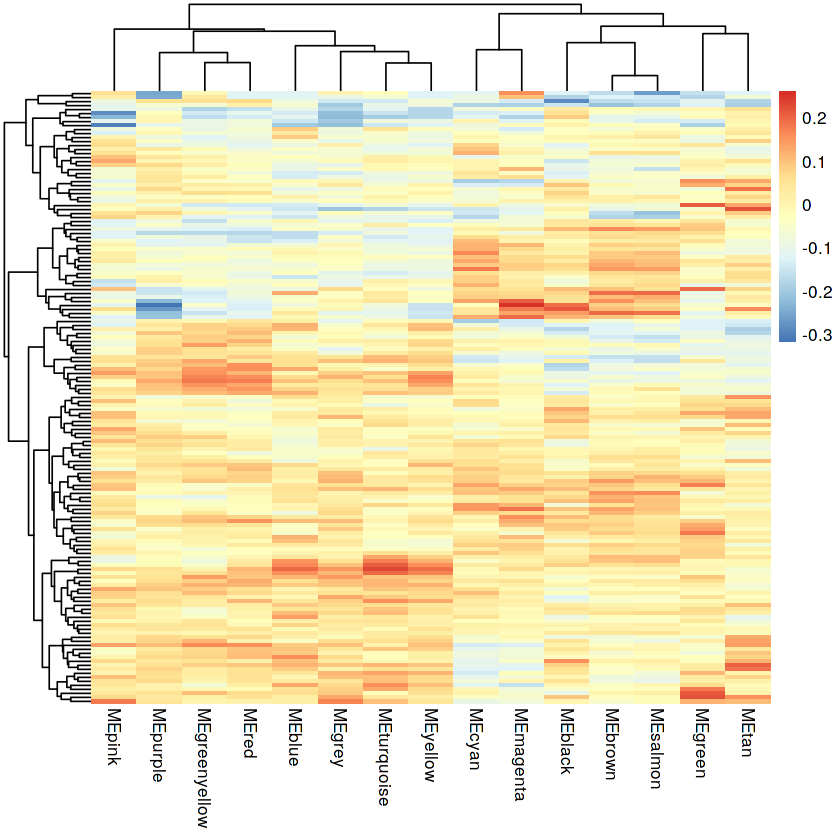

In [41]:
pheatmap(as.matrix(MEs_cancer))

#### Get GO enrichment terms

In [42]:
library(org.Hs.eg.db)
hs <- org.Hs.eg.db
genes <- colnames(cancer_top_genes)
conversion <- select(hs, 
       keys = genes,
       columns = c("ENTREZID", "SYMBOL"),
       keytype = "SYMBOL")
conversion <- conversion[!duplicated(conversion$SYMBOL), ]

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, w

In [43]:
head(conversion)
print (dim(conversion))

SYMBOL    ENTREZID
1 SNORA63   6043    
2 GSTA1     2938    
3 SMPX      23676   
4 HIST1H2BI 8346    
5 OR4N2     390429  
6 SLC18A3   6572

[1] 4000    2


In [28]:
GOenr = GOenrichmentAnalysis(labels = dynamicColors, entrezCodes = conversion$ENTREZID, organism = "human", nBestP = 5);

Warning message in GOenrichmentAnalysis(labels = dynamicColors, entrezCodes = conversion$ENTREZID, :
“This function is deprecated and will be removed in the near future. 
We suggest using the replacement function enrichmentAnalysis 
in R package anRichment, available from the following URL:
https://labs.genetics.ucla.edu/horvath/htdocs/CoexpressionNetwork/GeneAnnotation/”Loading required package: GO.db


 GOenrichmentAnalysis: loading annotation data...
  ..of the 3972  Entrez identifiers submitted, 3755 are mapped in current GO categories.
  ..will use 3755 background genes for enrichment calculations.
  ..preparing term lists (this may take a while).. 
  ..working on label set 1 ..
    ..calculating enrichments (this may also take a while)..
    ..putting together terms with highest enrichment significance..


In [29]:
enrichment_table <- GOenr$bestPTerms[[4]]$enrichment[, c('module', 'rank', 'termID', 'termName', 'termDefinition')]

In [30]:
enrichment_table

module      rank termID    
GO:0002376  black       1    GO:0002376
GO:0006955  black       2    GO:0006955
GO:0002682  black       3    GO:0002682
GO:0046649  black       4    GO:0046649
GO:0042110  black       5    GO:0042110
GO:0008366  blue        1    GO:0008366
GO:0042552  blue        2    GO:0042552
GO:0022010  blue        3    GO:0022010
GO:0014003  blue        4    GO:0014003
GO:0048709  blue        5    GO:0048709
GO:0006952  brown       1    GO:0006952
GO:00069551 brown       2    GO:0006955
GO:0006954  brown       3    GO:0006954
GO:00023761 brown       4    GO:0002376
GO:0002443  brown       5    GO:0002443
GO:0001944  cyan        1    GO:0001944
GO:0072358  cyan        2    GO:0072358
GO:0060712  cyan        3    GO:0060712
GO:0050730  cyan        4    GO:0050730
GO:0001568  cyan        5    GO:0001568
GO:0007017  green       1    GO:0007017
GO:0060271  green       2    GO:0060271
GO:0044782  green       3    GO:0044782
GO:0005930  green       4    GO:0005930
GO:0097014  green       5    GO:0097014
GO:0006357  greenyellow 1    GO:0006357
GO:0006366  greenyellow 2    GO:0006366
GO:0031018  greenyellow 3    GO:0031018
GO:0048699  greenyellow 4    GO:0048699
GO:0003357  greenyellow 5    GO:0003357
⋮           ⋮           ⋮    ⋮         
GO:0021781  purple      1    GO:0021781
GO:0021778  purple      2    GO:0021778
GO:0007399  purple      3    GO:0007399
GO:0030207  purple      4    GO:0030207
GO:0030208  purple      5    GO:0030208
GO:0048666  red         1    GO:0048666
GO:0031175  red         2    GO:0031175
GO:0030182  red         3    GO:0030182
GO:0099699  red         4    GO:0099699
GO:0022008  red         5    GO:0022008
GO:00069552 salmon      1    GO:0006955
GO:00023762 salmon      2    GO:0002376
GO:00024431 salmon      3    GO:0002443
GO:00069521 salmon      4    GO:0006952
GO:0043312  salmon      5    GO:0043312
GO:0034340  tan         1    GO:0034340
GO:0060337  tan         2    GO:0060337
GO:0071357  tan         3    GO:0071357
GO:0051607  tan         4    GO:0051607
GO:0009615  tan         5    GO:0009615
GO:0043005  turquoise   1    GO:0043005
GO:0045202  turquoise   2    GO:0045202
GO:0007268  turquoise   3    GO:0007268
GO:0098793  turquoise   4    GO:0098793
GO:0042995  turquoise   5    GO:0042995
GO:00452021 yellow      1    GO:0045202
GO:00430051 yellow      2    GO:0043005
GO:00072681 yellow      3    GO:0007268
GO:0030424  yellow      4    GO:0030424
GO:0050804  yellow      5    GO:0050804
            termName                                        
GO:0002376  immune system process                           
GO:0006955  immune response                                 
GO:0002682  regulation of immune system process             
GO:0046649  lymphocyte activation                           
GO:0042110  T cell activation                               
GO:0008366  axon ensheathment                               
GO:0042552  myelination                                     
GO:0022010  central nervous system myelination              
GO:0014003  oligodendrocyte development                     
GO:0048709  oligodendrocyte differentiation                 
GO:0006952  defense response                                
GO:00069551 immune response                                 
GO:0006954  inflammatory response                           
GO:00023761 immune system process                           
GO:0002443  leukocyte mediated immunity                     
GO:0001944  vasculature development                         
GO:0072358  cardiovascular system development               
GO:0060712  spongiotrophoblast layer development            
GO:0050730  regulation of peptidyl-tyrosine phosphorylation 
GO:0001568  blood vessel development                        
GO:0007017  microtubule-based process                       
GO:0060271  cilium assembly                                 
GO:0044782  cilium organization                             
GO:0005930  axoneme                                         
GO:0097

##  WGCNA Analysis on  Luminal B

#### Input data

In [44]:
cancer = read.csv('./WCGNA_analysis/lumB_data.csv', row.names = 1)

In [45]:
dim(cancer)

[1]   192 20530

pickSoftThreshold: will use block size 4000.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4000 of 4000
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.462 -3.29          0.887 448.000  4.13e+02  922.0
2      2    0.880 -1.81          0.875  93.300  6.79e+01  357.0
3      3    0.967 -1.44          0.963  30.800  1.45e+01  212.0
4      4    0.978 -1.27          0.971  14.400  3.63e+00  157.0
5      5    0.974 -1.18          0.972   8.430  1.09e+00  123.0
6      6    0.986 -1.12          0.990   5.580  3.74e-01  100.0
7      7    0.977 -1.10          0.981   3.970  1.38e-01   83.3
8      8    0.966 -1.10          0.968   2.960  5.34e-02   70.2
9      9    0.974 -1.10          0.976   2.270  2.13e-02   59.9
10    10    0.970 -1.11          0.967   1.790  8.76e-03   51.5
11    12    0.969 -1.13          0.964   1.160  1.79e-03   38.9
12    14    0.969 -1.12          0.965   0.794  3.82e-04   30.3
13    16    0

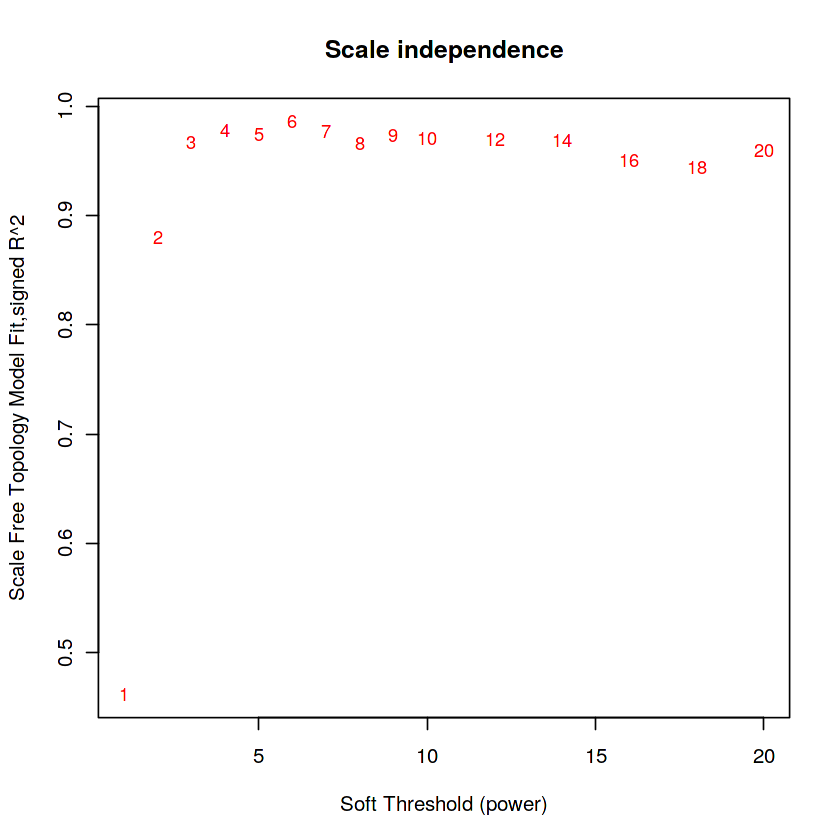

In [46]:
### Get most variable gene list for cancer
cv <- apply(cancer, 2, mad)

# Taking top 4000 by average expression
cancer_top_genes <- cancer[, order(cv, decreasing = T)]
cancer_top_genes <- cancer_top_genes[, 1:4000]

#### Choose Power for scale free topology for cancer 
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))
sft_cancer = pickSoftThreshold(cancer_top_genes, powerVector = powers, verbose = 5, RsquaredCut = 0.95)

plot(sft_cancer$fitIndices[,1], -sign(sft_cancer$fitIndices[,3])*sft_cancer$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft_cancer$fitIndices[,1], -sign(sft_cancer$fitIndices[,3])*sft_cancer$fitIndices[,2],
     labels=powers,cex=0.9,col="red")

#### Choose Power based on highest value of R^2 values to get scale free Topology :

In [47]:
sft_cancer$fitIndices$Power[which.max(sft_cancer$fitIndices$SFT.R.sq)]

[1] 6

#### Now construct modules based on TOM dissimilarity

In [48]:
power = 6

In [49]:
# Preparing for module list for cancer
TOM <- TOMsimilarityFromExpr(cancer_top_genes, networkType = "signed", TOMType = "signed", power = power)

# get dissimilarity matrix from TOM matrix
colnames(TOM) <- rownames(TOM)
dissTOM <- 1 - TOM

# hierarchical clustering of the genes based on the TOM dissimilarity measure
geneTree <- hclust(as.dist(dissTOM), method = "average")

# Set the minimum module size
minModuleSize <- 20

# cut the tree
# the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
dynamicMods <- cutreeDynamic(dendro = geneTree, method = "tree", minClusterSize = minModuleSize)
dynamicColors = labels2colors(dynamicMods)

MEList = moduleEigengenes(cancer_top_genes, colors = dynamicColors)
MEs_cancer = MEList$eigengenes

module_list_cancer <- list()
for (module_index in sort(unique(dynamicMods))){
   module <-  colnames(cancer_top_genes)[which(dynamicMods==module_index)]
   module <- module[!is.na(module)]
   module <- module[module != ""]
   module <- module[module != " "]
   # put brackets around every entrez id so to demarcate 1 genes
   module_list_cancer[[as.character(module_index)]] <- paste(module, collapse = ",")
}
module_list_cancer <- module_list_cancer[sapply(module_list_cancer, nchar) > 0]

TOM calculation: adjacency..
..will not use multithreading.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


#### We have assigned a color to each module
Grey contains unassigned genes

In [33]:
table(dynamicColors)

dynamicColors
    black      blue     brown     green      grey   magenta      pink       red 
       29       863       484        45      1276        25        25        35 
turquoise    yellow 
     1120        98 

#### Plot Module Dendogram with all colors (including grey)

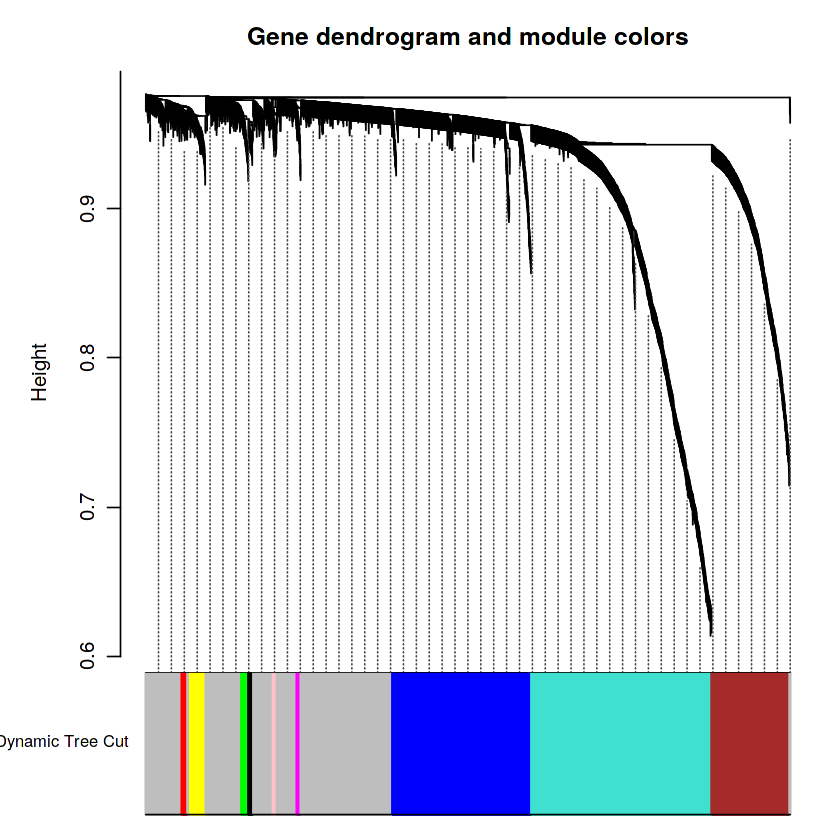

In [34]:
plotDendroAndColors(geneTree, dynamicColors, 
                    "Dynamic Tree Cut", dendroLabels = FALSE,
                    hang = 0.03, addGuide = TRUE,
                    guideHang = 0.05, main = "Gene dendrogram and module colors")

#### Remove the grey module genes as they are the unassigned ones

In [35]:
restGenes = (dynamicColors != "grey")
diss1 = 1 - TOMsimilarityFromExpr(cancer_top_genes[,restGenes], power = power)

TOM calculation: adjacency..
..will not use multithreading.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


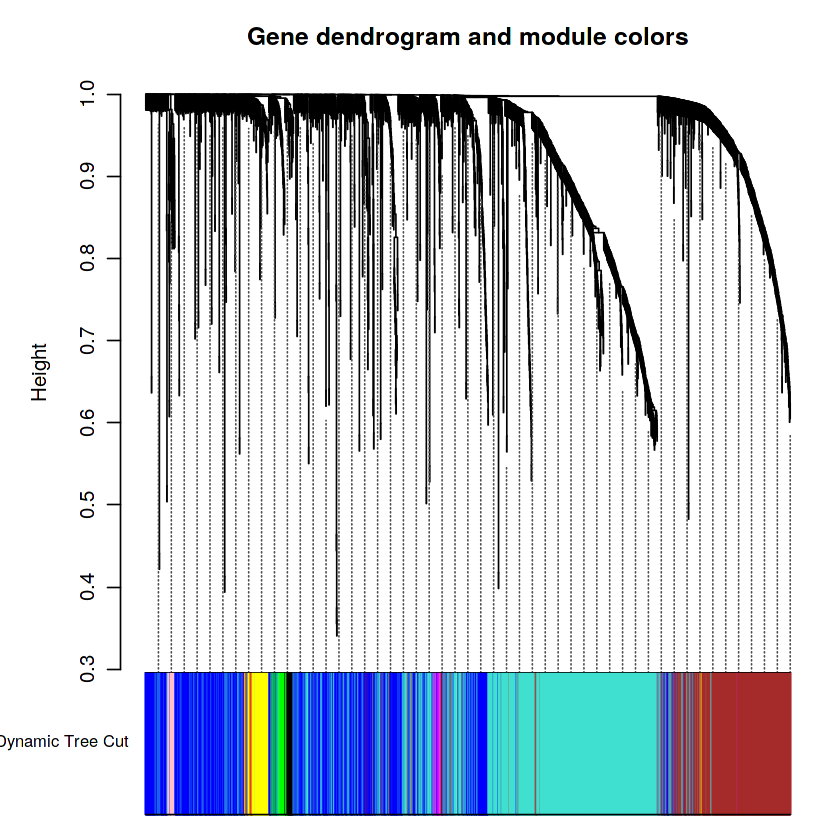

In [36]:
SubGeneNames <- colnames(cancer_top_genes)
colnames(diss1) = rownames(diss1) = SubGeneNames[restGenes]
hier1 = flashClust(as.dist(diss1), method="average" )
plotDendroAndColors(hier1, dynamicColors[restGenes],
                    "Dynamic Tree Cut", dendroLabels = FALSE,
                    hang = 0.03, addGuide = TRUE,
                    guideHang = 0.05, main = "Gene dendrogram and module colors")

#### Get Module Significance Boxplot :

In [37]:
### ---- This needs to be done ------- ###

#### Module Eigengenes (First PC) 

In [38]:
head(MEs_cancer)

MEblack     MEblue      MEbrown     MEgreen     MEgrey      MEmagenta  
1 -0.14254235 -0.08330870 -0.02381273 -0.08758924 -0.07034892 -0.02856009
2  0.01738643 -0.05076150  0.09679977 -0.05012774 -0.01223660  0.08431420
3 -0.03808201  0.13411048  0.03058569 -0.05095708  0.04473588  0.08582329
4  0.06665489 -0.15426480 -0.10244692  0.05184906  0.06319202 -0.03333780
5 -0.05640983  0.00530298  0.04725045 -0.07626635 -0.07167188 -0.01064816
6  0.08833318  0.14153063  0.02348164  0.08517534 -0.07290887  0.04116594
  MEpink      MEred         MEturquoise MEyellow   
1 -0.05894967  0.0006874564 0.005844450 -0.01376997
2 -0.02425383 -0.0206004039 0.077354985 -0.03937943
3 -0.06118836  0.0170013242 0.010820772  0.06065525
4 -0.08917795  0.1019605169 0.055668529 -0.02143978
5  0.12057347 -0.1032269323 0.009951965 -0.02129772
6 -0.12283284 -0.1018495715 0.063006448 -0.01169117

In [39]:
dim(MEs_cancer)

[1] 192  10

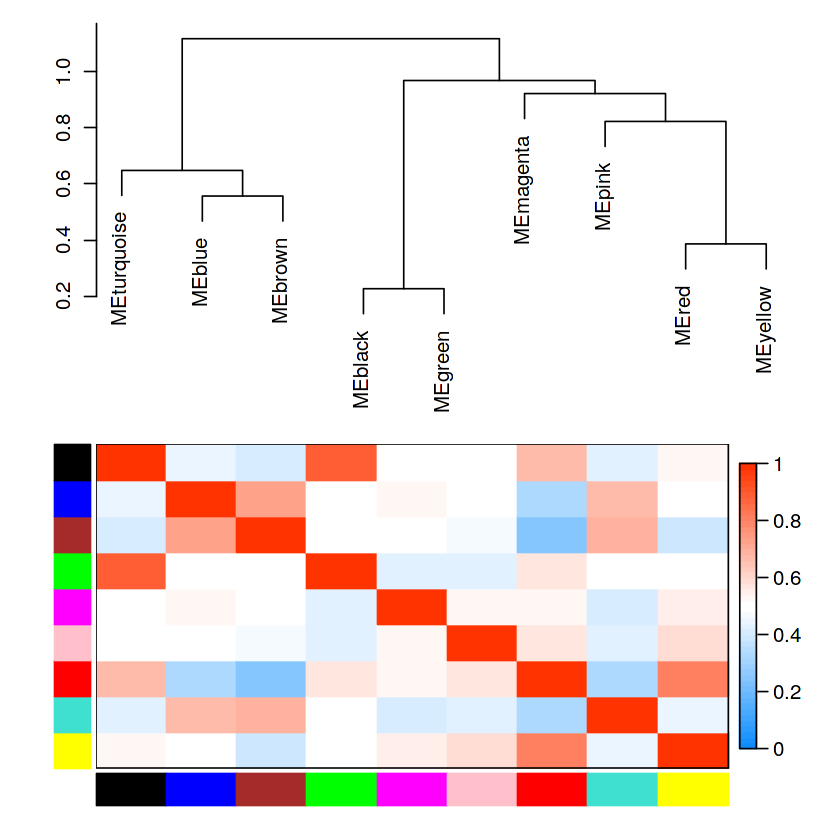

In [40]:
plotEigengeneNetworks(MEs_cancer, "", marDendro = c(0,4,1,2), marHeatmap = c(3,4,1,2))

#### Getting Hub Genes based for each module 

In [1]:
chooseTopHubInEachModule(
   cancer_top_genes, 
   dynamicColors, 
   omitColors = "grey", 
   power = power, 
   type = "signed")

ERROR: Error in chooseTopHubInEachModule(cancer_top_genes, dynamicColors, omitColors = "grey", : could not find function "chooseTopHubInEachModule"


#### Gene Module Membership which is basically the correlation coefficient of the gene with the module eigenGene

In [42]:
SubGeneNames <- colnames(cancer_top_genes)
module_colors= setdiff(unique(dynamicColors), "grey")
geneModuleMembership = as.data.frame(cor(cancer_top_genes, MEs_cancer, use = "p"));
head(geneModuleMembership)

MEblack     MEblue     MEbrown     MEgreen      MEgrey     
GSTM1   -0.01382652 0.03219311  0.13876148 -0.054285722  0.05550937
TFAP2B   0.11367769 0.28094875  0.18253356  0.229017073 -0.16069126
CLEC3A   0.10059190 0.11837242  0.13690200  0.136684585 -0.02723060
MUC5B   -0.05470468 0.26551899  0.18612664 -0.037553740 -0.31882292
VSTM2A   0.01350054 0.03032121 -0.07324747  0.006672829  0.06449977
SCGB2A2  0.01394158 0.24598070  0.21554016 -0.021804547 -0.12212931
        MEmagenta    MEpink      MEred        MEturquoise MEyellow    
GSTM1   -0.098305666  0.06231287 -0.003774462 0.09160881  -0.032894190
TFAP2B  -0.055346524 -0.24373107 -0.352753344 0.23681086  -0.224331051
CLEC3A   0.008909645 -0.21309127 -0.174542387 0.08146803  -0.006800822
MUC5B    0.110409000 -0.05462224 -0.348172700 0.14127187   0.008133858
VSTM2A   0.044181912  0.11709988  0.081079195 0.03124226   0.242671442
SCGB2A2 -0.113086458 -0.07009721 -0.324844810 0.11679944  -0.180245063

#### Getting Top Ranked Genes in each Module based on correlation with module eigenGene

In [43]:
for (color in module_colors){
    print (paste("Print top 10 genes by Module Membership : ", color, sep = ""))
    x = geneModuleMembership[order(geneModuleMembership[, paste("ME", color, sep="")], decreasing= T),]
    print (rownames(x[1:10,]))
}

[1] "Print top 10 genes by Module Membership : blue"
 [1] "HSPB6"    "TMEM100"  "TMEM132C" "SLC19A3"  "CHRDL1"   "GPD1"    
 [7] "PLIN1"    "RBP4"     "CIDEC"    "CIDEA"   
[1] "Print top 10 genes by Module Membership : turquoise"
 [1] "CCR5"   "PTPN7"  "IL2RG"  "SLAMF1" "CD48"   "IKZF1"  "SNX20"  "CD2"   
 [9] "LCK"    "SLA2"  
[1] "Print top 10 genes by Module Membership : red"
 [1] "FLJ35390" "FAM57B"   "KCNC1"    "WDR17"    "ICA1L"    "RUNDC3A" 
 [7] "BSN"      "NEURL"    "CST9"     "ASB16"   
[1] "Print top 10 genes by Module Membership : brown"
 [1] "THBS2"  "COL1A2" "COL5A2" "COL3A1" "MMP2"   "LUM"    "ADAM12" "FIBIN" 
 [9] "COL1A1" "COL5A1"
[1] "Print top 10 genes by Module Membership : yellow"
 [1] "RUNDC3A" "UNC13A"  "DLGAP3"  "CHRNB2"  "SYP"     "PHF21B"  "SNAP25" 
 [8] "BSN"     "VGF"     "HCN2"   
[1] "Print top 10 genes by Module Membership : green"
 [1] "YSK4"     "ZBBX"     "CDHR4"    "ROPN1L"   "CCDC135"  "C1orf194"
 [7] "FOXJ1"    "FOXN4"    "WDR38"    "RSPH4A"  
[1] 

#### Get Module eigengene heatmap

In [44]:
library(pheatmap)

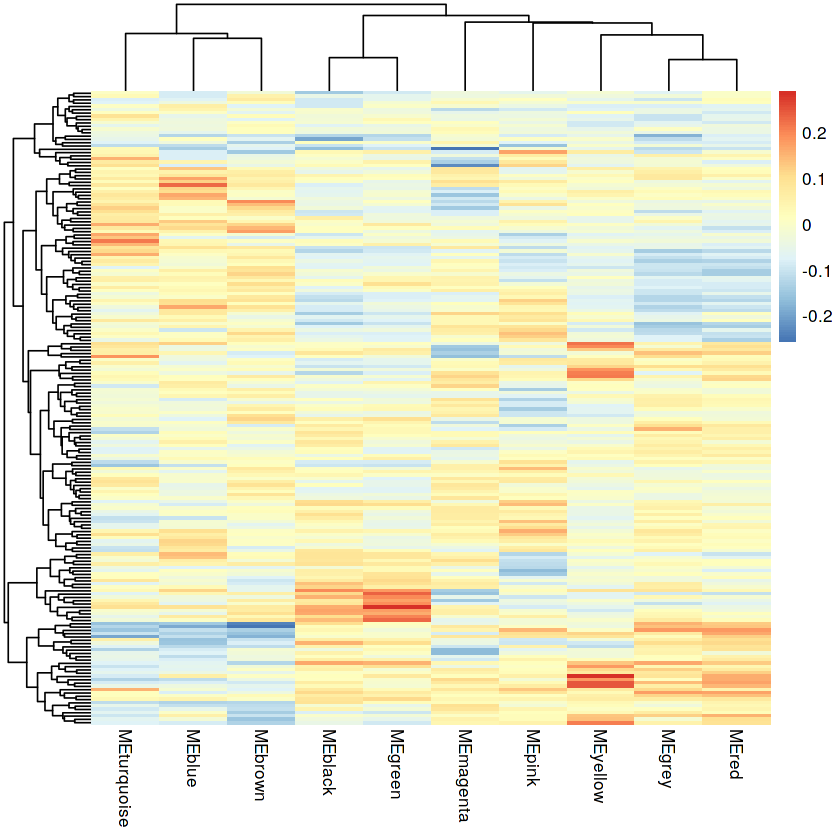

In [45]:
pheatmap(as.matrix(MEs_cancer))

#### Get GO enrichment terms

In [47]:
library(org.Hs.eg.db)
hs <- org.Hs.eg.db
genes <- colnames(cancer_top_genes)
conversion <- select(hs, 
       keys = genes,
       columns = c("ENTREZID", "SYMBOL"),
       keytype = "SYMBOL")
conversion <- conversion[!duplicated(conversion$SYMBOL), ]

'select()' returned 1:1 mapping between keys and columns


In [48]:
head(conversion)
print (dim(conversion))

SYMBOL  ENTREZID
1 GSTM1   2944    
2 TFAP2B  7021    
3 CLEC3A  10143   
4 MUC5B   727897  
5 VSTM2A  222008  
6 SCGB2A2 4250

[1] 4000    2


In [53]:
GOenr = GOenrichmentAnalysis(labels = dynamicColors, entrezCodes = conversion$ENTREZID, organism = "human", nBestP = 5);

Warning message in GOenrichmentAnalysis(labels = dynamicColors, entrezCodes = conversion$ENTREZID, :
“This function is deprecated and will be removed in the near future. 
We suggest using the replacement function enrichmentAnalysis 
in R package anRichment, available from the following URL:
https://labs.genetics.ucla.edu/horvath/htdocs/CoexpressionNetwork/GeneAnnotation/”

 GOenrichmentAnalysis: loading annotation data...
  ..of the 3544  Entrez identifiers submitted, 3383 are mapped in current GO categories.
  ..will use 3383 background genes for enrichment calculations.
  ..preparing term lists (this may take a while).. 
  ..working on label set 1 ..
    ..calculating enrichments (this may also take a while)..
    ..putting together terms with highest enrichment significance..


In [54]:
enrichment_table <- GOenr$bestPTerms[[4]]$enrichment[, c('module', 'rank', 'termID', 'termName', 'termDefinition')]

In [55]:
enrichment_table

module    rank termID    
GO:0007017  black     1    GO:0007017
GO:0060271  black     2    GO:0060271
GO:0044782  black     3    GO:0044782
GO:0015630  black     4    GO:0015630
GO:0005929  black     5    GO:0005929
GO:0005811  blue      1    GO:0005811
GO:0060612  blue      2    GO:0060612
GO:0043171  blue      3    GO:0043171
GO:0003413  blue      4    GO:0003413
GO:0003429  blue      5    GO:0003429
GO:0030198  brown     1    GO:0030198
GO:0043062  brown     2    GO:0043062
GO:0031012  brown     3    GO:0031012
GO:0030199  brown     4    GO:0030199
GO:0001501  brown     5    GO:0001501
GO:00059291 green     1    GO:0005929
GO:0007018  green     2    GO:0007018
GO:0003341  green     3    GO:0003341
GO:00070171 green     4    GO:0007017
GO:0035082  green     5    GO:0035082
GO:0007409  grey      1    GO:0007409
GO:0061564  grey      2    GO:0061564
GO:0003707  grey      3    GO:0003707
GO:0005874  grey      4    GO:0005874
GO:0045211  grey      5    GO:0045211
GO:0050790  magenta   1    GO:0050790
GO:0004674  magenta   2    GO:0004674
GO:0005829  magenta   3    GO:0005829
GO:0005634  magenta   4    GO:0005634
GO:0007257  magenta   5    GO:0007257
GO:0000786  pink      1    GO:0000786
GO:0032993  pink      2    GO:0032993
GO:0000785  pink      3    GO:0000785
GO:0006325  pink      4    GO:0006325
GO:0005694  pink      5    GO:0005694
GO:0018406  red       1    GO:0018406
GO:0035268  red       2    GO:0035268
GO:0097502  red       3    GO:0097502
GO:0000030  red       4    GO:0000030
GO:0007281  red       5    GO:0007281
GO:0006955  turquoise 1    GO:0006955
GO:0002376  turquoise 2    GO:0002376
GO:0006952  turquoise 3    GO:0006952
GO:0002682  turquoise 4    GO:0002682
GO:0045321  turquoise 5    GO:0045321
GO:0045202  yellow    1    GO:0045202
GO:0043005  yellow    2    GO:0043005
GO:0030424  yellow    3    GO:0030424
GO:0099504  yellow    4    GO:0099504
GO:0099003  yellow    5    GO:0099003
            termName                                                               
GO:0007017  microtubule-based process                                              
GO:0060271  cilium assembly                                                        
GO:0044782  cilium organization                                                    
GO:0015630  microtubule cytoskeleton                                               
GO:0005929  cilium                                                                 
GO:0005811  lipid droplet                                                          
GO:0060612  adipose tissue development                                             
GO:0043171  peptide catabolic process                                              
GO:0003413  chondrocyte differentiation involved in endochondral bone morphogenesis
GO:0003429  growth plate cartilage chondrocyte morphogenesis                       
GO:0030198  extracellular matrix organization                                      
GO:0043062  extracellular structure organization                                   
GO:0031012  extracellular matrix                                                   
GO:0030199  collagen fibril organization                                           
GO:0001501  skeletal system development                                            
GO:00059291 cilium                                                                 
GO:0007018  microtubule-based movement                                             
GO:0003341  cilium movement                                                        
GO:00070171 microtubule-based process                                              
GO:0035082  axoneme assembly                                                       
GO:0007409  axonogenesis                                                           
GO:0061564  axon development                                                       
GO:0003707  steroid hormone receptor activity                                      
GO:0005874  microtubule                                   